# Figure 3: Plot sea ice volume tendency components

Plot the thermodynamic and dynamic volume tendency components. Both are calculated online.

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import cmocean as cmo
import matplotlib.pyplot as plt
import subprocess

import matplotlib.gridspec as gridspec

User inputs

In [2]:
#model info
diri      = '/g/data/gh9/wgh581/ROMS_Output/metroms_files/RAW/'
cntr_expt = 'metroms_CONTROL' 
pert_2expt = 'metroms_2SSFLUX'
pert_4expt = 'metroms_4SSFLUX'
varname   = ['dvidtt','dvidtd']  #variable names

#time domain for each experimnt
yrst = 2002 ; mst = 2
yren = 2011 ; men = 11 

#spatial domain (self-explanatory)
# latmax = -50.
# lonmin = 140.
# lonmax = 300. 

#output file destination
diro = ''

In [3]:
path_to_data = '/g/data/gh9/wgh581/ROMS_Output/metroms_files/POST_PROCESS/'

Note on raw data:

The output is saved as 5-day averages with the date of the next day (i.e. 10-14 Mar are saved in 15 Mar). The seasonal climatalogy is based on the month of the output data. While this is not accurate in terms of the name given to a season, it is consistent between years and simulations. 

Import previously loaded data

In [4]:
cntr   = xr.open_dataset(path_to_data + 'dvdt_CONTROL_2002_2011_full_circumpolar.nc')
pert_2 = xr.open_dataset(path_to_data + 'dvdt_2SSFLUX_2002_2011_full_circumpolar.nc')
pert_4 = xr.open_dataset(path_to_data + 'dvdt_4SSFLUX_2002_2011_full_circumpolar.nc')

Plotting information

In [5]:
# Spherical coordinates
deg2rad = np.pi/180.0

# CICE
x_cice = -(cntr.TLAT+90)*np.cos(cntr.TLON*deg2rad+np.pi/2)
y_cice =  (cntr.TLAT+90)*np.sin(cntr.TLON*deg2rad+np.pi/2)

In [6]:
# Load roms data for plotting
roms = xr.open_dataset('/g/data/gh9/wgh581/ROMS_Output/metroms_files/' + 'RAW/metroms_CONTROL/' + 'ocean_his_0042.nc')
lat_roms = roms.lat_rho[:-15,:-1]#.where((roms.lat_rho <= latmax) & (roms.lon_rho >= lonmin) & (roms.lon_rho <= lonmax), drop=True)[1:,:]
lon_roms = roms.lon_rho[:-15,:-1]
zice     = roms.zice[:-15,:-1]
h        = roms.h[:-15,:-1]
mask     = roms.mask_rho[:-15,:-1]

In [7]:
# Masking
h     = np.ma.masked_where(mask==0, h)
zice  = np.ma.masked_where(mask==0, zice)
zice  = np.ma.masked_where(zice==0, zice)
lat_r = np.ma.masked_where(mask==1, lat_roms)

In [8]:
# ROMS
x_roms = -(lat_roms+90)*np.cos(lon_roms*deg2rad+np.pi/2)
y_roms =  (lat_roms+90)*np.sin(lon_roms*deg2rad+np.pi/2)

In [9]:
# Center of missing circle (ROMS)
lat_c   = -83
lon_c   = 50
# Radius of missing circle (play around with this until it works)
radius  = 10.1
# Find center in spherical coordinates
x_c_metroms = -(lat_c+90)*np.cos(lon_c*deg2rad+np.pi/2)
y_c_metroms =  (lat_c+90)*np.sin(lon_c*deg2rad+np.pi/2)
# Build a regular x-y grid and select the missing circle
lat_max = -63+90
x_reg, y_reg = np.meshgrid(np.linspace(-lat_max, lat_max, num=1000), np.linspace(-lat_max, lat_max, num=1000))
land_circle  = np.zeros(np.shape(x_reg))
land_circle_metroms = np.ma.masked_where(np.sqrt((x_reg-x_c_metroms)**2 + (y_reg-y_c_metroms)**2) > radius, land_circle)

In [10]:
# Region range
xlim_min = -25
xlim_max = 15
ylim_min = -30
ylim_max = 7

In [11]:
# # Make sure the coordinates are exactly the same
# x_cice.TLON.values = x_roms.lon_rho.values
# x_cice.TLAT.values = x_roms.lat_rho.values

Seasonal climatology (full time period)

In [12]:
# Control
cntr_t_seasonal = cntr.dvidtt.groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
cntr_d_seasonal = cntr.dvidtd.groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
# Doubling
pert_2_t_seasonal = pert_2.dvidtt.groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
pert_2_d_seasonal = pert_2.dvidtd.groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
# Quadrupling
pert_4_t_seasonal = pert_4.dvidtt.groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
pert_4_d_seasonal = pert_4.dvidtd.groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))

Mask for sea ice area

In [13]:
# Sea ice area (for masking)
aice_extmin = 0.15
path = '/g/data/gh9/wgh581/ROMS_Output/metroms_files/'
aice_cntr   = xr.open_dataset(path + 'POST_PROCESS/aice_hi_CONTROL_2002_2011_full_circumpolar.nc').aice.sel(time=slice('2008-12-01','2011-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
aice_pert_2 = xr.open_dataset(path + 'POST_PROCESS/aice_hi_2SSFLUX_2002_2011_full_circumpolar.nc').aice.sel(time=slice('2008-12-01','2011-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
aice_pert_4 = xr.open_dataset(path + 'POST_PROCESS/aice_hi_4SSFLUX_2002_2011_full_circumpolar.nc').aice.sel(time=slice('2008-12-01','2011-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))

In [14]:
cntr_t_masked = cntr_t_seasonal.where(aice_cntr > aice_extmin, np.nan)

In [15]:
# Masking
cntr_t_masked = cntr_t_seasonal.where(aice_cntr > aice_extmin, np.nan)
cntr_d_masked = cntr_d_seasonal.where(aice_cntr > aice_extmin, np.nan)

pert_2_t_masked = pert_2_t_seasonal.where(aice_pert_2 > aice_extmin, np.nan)
pert_2_d_masked = pert_2_d_seasonal.where(aice_pert_2 > aice_extmin, np.nan)

pert_4_t_masked = pert_4_t_seasonal.where(aice_pert_4 > aice_extmin, np.nan)
pert_4_d_masked = pert_4_d_seasonal.where(aice_pert_4 > aice_extmin, np.nan)

Calculate anomalies

In [16]:
# pert_2 - CNTR
diff_2_t = pert_2_t_masked - cntr_t_masked
diff_2_d = pert_2_d_masked - cntr_d_masked
diff_2_total = (diff_2_t + diff_2_d)

# pert_4 - CNTR
diff_4_t = pert_4_t_masked - cntr_t_masked
diff_4_d = pert_4_d_masked - cntr_d_masked
diff_4_total = (diff_4_t + diff_4_d)

### Plotting

Full time period to account for time-integrated tendency terms.

In [17]:
season = ['Summer', 'Autumn', 'Winter', 'Spring']
ft_size = 14
my_dpi  = 150

# Colorbar
from palettable.scientific.diverging import Vik_19_r
from palettable.colorbrewer.diverging import PRGn_5_r

panel_name = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)']#, 'm)', 'n)', 'o)', 'p)']

fig_path = '/g/data/gh9/wgh581/Python_code/MetROMS_BasalMelt_Perturbation/figures/'

In [18]:
def plot_region():
    plt.tick_params(labelleft=False, labelbottom=False)
    plt.contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    plt.contourf(x_roms, y_roms, lat_r, colors='0.5')
    plt.contourf(x_roms, y_roms, zice*1, colors='k')
    plt.contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    plt.contour(x_cice, y_cice, aice_cntr[ii,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    plt.tick_params(axis='both', which='both', length=0)
    plt.xlim(xlim_min, xlim_max)
    plt.ylim(ylim_min, ylim_max)

Volume tendency, doubling

/jobfs/88948030.gadi-pbs/ipykernel_631465/2416477624.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = plt.pcolormesh(x_cice, y_cice, diff_2_total[ii]*90*1e-2, vmin=-0.25, vmax=0.25, cmap=Vik_19_r.mpl_colormap)
/jobfs/88948030.gadi-pbs/ipykernel_631465/2416477624.py:25: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = plt.pcolormesh(x_cice, y_cice, diff_2_t[ii]*90*1e-2, vmin=-0.25, vmax=0.25, cmap=Vik_19_r.mpl_colormap)
/jobfs/88948030.gadi-pbs/ipykernel_631465/2416477624.py:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not 

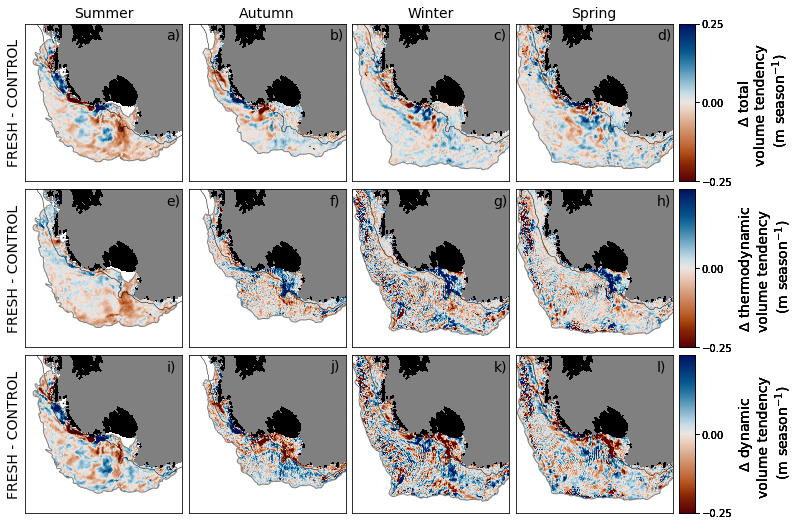

In [63]:
fig = plt.figure(figsize=(12,9))

gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[2], wspace=0.05)

for ii in range(4):
    
    ax = fig.add_subplot(gs0[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_2_total[ii]*90*1e-2, vmin=-0.25, vmax=0.25, cmap=Vik_19_r.mpl_colormap)
    plt.title(season[ii], fontsize=ft_size)
    ax.text(0.9, 0.9, panel_name[ii], fontsize=ft_size, transform=ax.transAxes)
    plot_region()
    if ii == 0:
        plt.ylabel('FRESH - CONTROL', fontsize=ft_size)
    cbar_ax0 = fig.add_subplot(gs0[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0, ticks=np.arange(-0.25, 0.5, 0.25))
    cbar.set_label('$\Delta$ total\nvolume tendency \n (m season$^{-1}$)', fontsize=ft_size)

    ax = fig.add_subplot(gs1[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_2_t[ii]*90*1e-2, vmin=-0.25, vmax=0.25, cmap=Vik_19_r.mpl_colormap)
    ax.text(0.9, 0.9, panel_name[ii+4], fontsize=ft_size, transform=ax.transAxes)
    plot_region()
    if ii == 0:
        plt.ylabel('FRESH - CONTROL', fontsize=ft_size)
    cbar_ax0 = fig.add_subplot(gs1[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0, ticks=np.arange(-0.25, 0.25, 0.25))
    cbar.set_label('$\Delta$ thermodynamic\nvolume tendency \n (m season$^{-1}$)', fontsize=ft_size)
    
    ax = fig.add_subplot(gs2[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_2_d[ii]*90*1e-2, vmin=-0.25, vmax=0.25, cmap=Vik_19_r.mpl_colormap)
    ax.text(0.9, 0.9, panel_name[ii+8], fontsize=ft_size, transform=ax.transAxes)
    plot_region()
    if ii == 0:
        plt.ylabel('FRESH - CONTROL', fontsize=ft_size)
    cbar_ax0 = fig.add_subplot(gs2[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0, ticks=np.arange(-0.25, 0.25, 0.25))
    cbar.set_label('$\Delta$ dynamic\nvolume tendency \n (m season$^{-1}$)', fontsize=ft_size)
    
save_fig = 1
if save_fig == 1:
    plt.savefig(fig_path + 'Figure3.png', dpi=my_dpi, bbox_inches='tight', facecolor='white')

Volume tendency, quadrupling

/jobfs/88948030.gadi-pbs/ipykernel_631465/1447126363.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = plt.pcolormesh(x_cice, y_cice, diff_4_total[ii]*90*1e-2, vmin=-0.25, vmax=0.25, cmap=Vik_19_r.mpl_colormap)
/jobfs/88948030.gadi-pbs/ipykernel_631465/1447126363.py:25: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = plt.pcolormesh(x_cice, y_cice, diff_4_t[ii]*90*1e-2, vmin=-0.25, vmax=0.25, cmap=Vik_19_r.mpl_colormap)
/jobfs/88948030.gadi-pbs/ipykernel_631465/1447126363.py:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not 

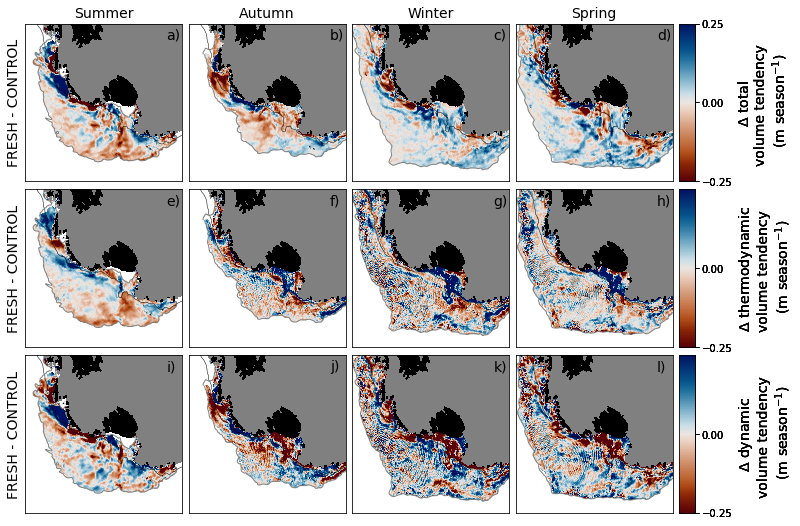

In [65]:
fig = plt.figure(figsize=(12,9))

gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[2], wspace=0.05)

for ii in range(4):
    
    ax = fig.add_subplot(gs0[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_4_total[ii]*90*1e-2, vmin=-0.25, vmax=0.25, cmap=Vik_19_r.mpl_colormap)
    plt.title(season[ii], fontsize=ft_size)
    ax.text(0.9, 0.9, panel_name[ii], fontsize=ft_size, transform=ax.transAxes)
    plot_region()
    if ii == 0:
        plt.ylabel('FRESH - CONTROL', fontsize=ft_size)
    cbar_ax0 = fig.add_subplot(gs0[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0, ticks=np.arange(-0.25, 0.5, 0.25))
    cbar.set_label('$\Delta$ total\nvolume tendency \n (m season$^{-1}$)', fontsize=ft_size)

    ax = fig.add_subplot(gs1[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_4_t[ii]*90*1e-2, vmin=-0.25, vmax=0.25, cmap=Vik_19_r.mpl_colormap)
    ax.text(0.9, 0.9, panel_name[ii+4], fontsize=ft_size, transform=ax.transAxes)
    plot_region()
    if ii == 0:
        plt.ylabel('FRESH - CONTROL', fontsize=ft_size)
    cbar_ax0 = fig.add_subplot(gs1[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0, ticks=np.arange(-0.25, 0.25, 0.25))
    cbar.set_label('$\Delta$ thermodynamic\nvolume tendency \n (m season$^{-1}$)', fontsize=ft_size)
    
    ax = fig.add_subplot(gs2[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, diff_4_d[ii]*90*1e-2, vmin=-0.25, vmax=0.25, cmap=Vik_19_r.mpl_colormap)
    ax.text(0.9, 0.9, panel_name[ii+8], fontsize=ft_size, transform=ax.transAxes)
    plot_region()
    if ii == 0:
        plt.ylabel('FRESH - CONTROL', fontsize=ft_size)
    cbar_ax0 = fig.add_subplot(gs2[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0, ticks=np.arange(-0.25, 0.25, 0.25))
    cbar.set_label('$\Delta$ dynamic\nvolume tendency \n (m season$^{-1}$)', fontsize=ft_size)
    
save_fig = 1
if save_fig == 1:
    plt.savefig(fig_path + 'Figure3_4SSFLUX.png', dpi=my_dpi, bbox_inches='tight', facecolor='white')

Volume tendency in control

/jobfs/88948030.gadi-pbs/ipykernel_631465/2254401972.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = plt.pcolormesh(x_cice, y_cice, cntr_t_masked[ii]*90*1e-2, vmin=-1, vmax=1, cmap=Vik_19_r.mpl_colormap)
/jobfs/88948030.gadi-pbs/ipykernel_631465/2254401972.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = plt.pcolormesh(x_cice, y_cice, cntr_d_masked[ii]*90*1e-2, vmin=-1, vmax=1, cmap=Vik_19_r.mpl_colormap)


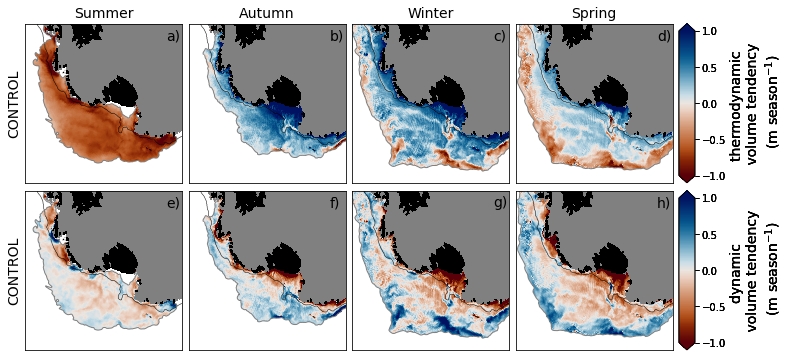

In [68]:
fig = plt.figure(figsize=(12,6))

gs = gridspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)

for ii in range(4):

    ax = fig.add_subplot(gs0[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, cntr_t_masked[ii]*90*1e-2, vmin=-1, vmax=1, cmap=Vik_19_r.mpl_colormap)
    plt.title(season[ii], fontsize=ft_size)
    ax.text(0.9, 0.9, panel_name[ii], fontsize=ft_size, transform=ax.transAxes)
    plot_region()
    if ii == 0:
        plt.ylabel('CONTROL', fontsize=ft_size)
    cbar_ax0 = fig.add_subplot(gs0[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0, ticks=np.arange(-1, 1.25, 0.5), extend='both')
    cbar.set_label('thermodynamic \n volume tendency \n (m season$^{-1}$)', fontsize=ft_size)
    
    ax = fig.add_subplot(gs1[0,ii])
    sc = plt.pcolormesh(x_cice, y_cice, cntr_d_masked[ii]*90*1e-2, vmin=-1, vmax=1, cmap=Vik_19_r.mpl_colormap)
    ax.text(0.9, 0.9, panel_name[ii+4], fontsize=ft_size, transform=ax.transAxes)
    plot_region()
    if ii == 0:
        plt.ylabel('CONTROL', fontsize=ft_size)
    cbar_ax0 = fig.add_subplot(gs1[:,-1])
    cbar = plt.colorbar(sc, cax=cbar_ax0, ticks=np.arange(-1, 1.25, 0.5), extend='both')
    cbar.set_label('dynamic \n volume tendency \n (m season$^{-1}$)', fontsize=ft_size)
    
save_fig = 1
if save_fig == 1:
    plt.savefig(fig_path + 'FigureS3.png', dpi=my_dpi, bbox_inches='tight', facecolor='white')

### Quantification of volume tendency (Ross Sea area)

In [ ]:
print('')
print('Change in SIC, trend CONTROL:')
for tt in range(4):
    test_model_ma_1 = trend_seasonal.where( (trend_seasonal.TLON>160) & (trend_seasonal.TLON<190) )
    test_model_ma_2 = test_model_ma_1.where((trend_seasonal.TLAT < -71.5) | (trend_seasonal.TLON>170))
    test_model_ma_3 = test_model_ma_2.where(trend_seasonal.TLAT < -71.5)
    test_model_ma_h = test_model_ma_2[tt,:-15,:-1].where(h[1:-1,1:-1] < 1000)
    area_mean = nanmean(test_model_ma_h)
    print(season[tt], round(area_mean, 4))